Submisson by Ajith Shenoy
- Ajithshenoy19@gmail.com

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Installing and Importing All Req. Libraries

In [ ]:
!pip install -U gdown Augmentor --quiet

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os
import PIL
from glob import glob

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

from sklearn.metrics import accuracy_score

import gdown #download directly from GDRIVE
import Augmentor # for Augmentations

In [ ]:
# Defining Utility Functions

def plot_training_history(history, epochs=20):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

### Downloading Data from Upgrad Shared Gdrive

In [ ]:
upgrad_dataset_url =  "https://drive.google.com/uc?id=1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs"

In [ ]:
output = 'melanoma_imgs.zip'
gdown.download(upgrad_dataset_url, output, quiet=False)
!unzip -q /content/melanoma_imgs.zip

Downloading...
From (uriginal): https://drive.google.com/uc?id=1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs
From (redirected): https://drive.google.com/uc?id=1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs&confirm=t&uuid=54380aac-ca22-433a-9584-6e341dba5d14
To: /content/melanoma_imgs.zip
100%|██████████| 824M/824M [00:03<00:00, 208MB/s]


In [ ]:
# Defining Paths
root  =  "./Skin cancer ISIC The International Skin Imaging Collaboration"
data_dir_train = pathlib.Path("./Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("./Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(f"Training Images : {image_count_train}\n")
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(f"Test Images: {image_count_test}\n")

Training Images : 2239

Test Images: 118



In [ ]:
# Creating A Dataframe for path and Class mapping
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]


dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])

display(original_df.sample(5))
del dataframe_dict_original

,Path,Label
1760,Skin cancer ISIC The International Skin Imagin...,seborrheic keratosis
230,Skin cancer ISIC The International Skin Imagin...,pigmented benign keratosis
823,Skin cancer ISIC The International Skin Imagin...,basal cell carcinoma
1023,Skin cancer ISIC The International Skin Imagin...,basal cell carcinoma
84,Skin cancer ISIC The International Skin Imagin...,vascular lesion


### Creating Data Loaders

In [ ]:
# Setting Parameters
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
## training data loader
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

## validation data loader
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# Classes
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Classes : {class_names} , {num_classes} number of classes.\n")

Classes : ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'] , 9 number of classes.



### Vizualizing Sample for each class

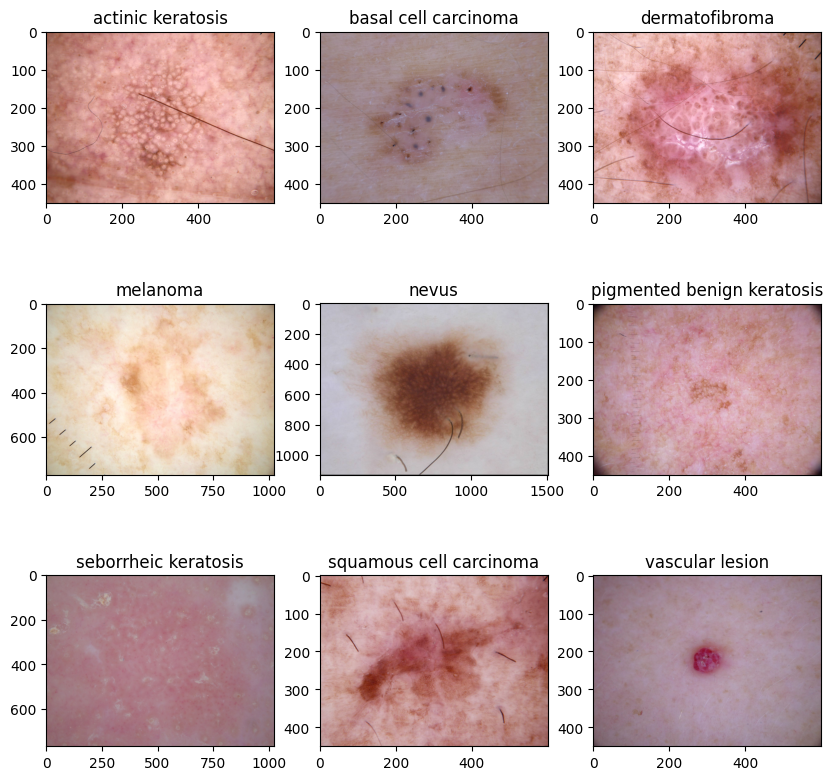

In [ ]:
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

### Creating and Training Initial Model

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Model Architecture

model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))


# Compile model and choose optimizer
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                   

Epoch 1/20
56/56 - 28s - loss: 2.0730 - accuracy: 0.1836 - val_loss: 2.0485 - val_accuracy: 0.2058 - 28s/epoch - 504ms/step
Epoch 2/20
56/56 - 5s - loss: 2.0250 - accuracy: 0.2081 - val_loss: 2.0237 - val_accuracy: 0.1924 - 5s/epoch - 89ms/step
Epoch 3/20
56/56 - 5s - loss: 2.0197 - accuracy: 0.1992 - val_loss: 2.0028 - val_accuracy: 0.2125 - 5s/epoch - 88ms/step
Epoch 4/20
56/56 - 5s - loss: 1.8890 - accuracy: 0.2935 - val_loss: 1.7915 - val_accuracy: 0.3154 - 5s/epoch - 88ms/step
Epoch 5/20
56/56 - 5s - loss: 1.7764 - accuracy: 0.3404 - val_loss: 1.6391 - val_accuracy: 0.4049 - 5s/epoch - 89ms/step
Epoch 6/20
56/56 - 5s - loss: 1.6536 - accuracy: 0.3923 - val_loss: 1.5976 - val_accuracy: 0.4586 - 5s/epoch - 89ms/step
Epoch 7/20
56/56 - 5s - loss: 1.5451 - accuracy: 0.4542 - val_loss: 1.5720 - val_accuracy: 0.4452 - 5s/epoch - 89ms/step
Epoch 8/20
56/56 - 5s - loss: 1.4614 - accuracy: 0.4704 - val_loss: 1.4767 - val_accuracy: 0.4899 - 5s/epoch - 88ms/step
Epoch 9/20
56/56 - 5s - loss:

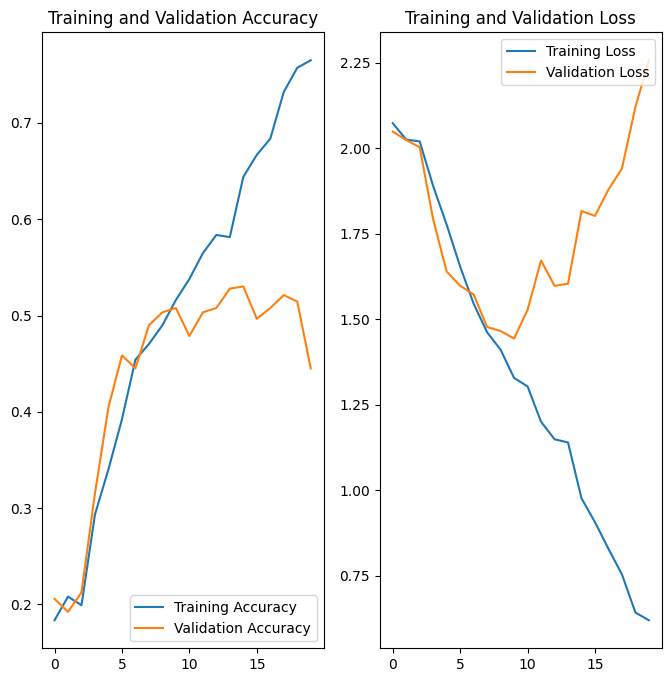

In [ ]:
# Model Training

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose =  2
)

## plotting training history
plot_training_history(history)

### Initial Observations on Overfitting or Underfitting
- Model is Clearly Overfitting as train and validation loss are significantly different.
- The training loss keeps decreasing but validation loss spikes up , indicating overfitting after 11th Epoch.

### Basic Augmentation Model.
- Trying Basic Augmentations to address Overfitting

In [ ]:
# Defining Basic Data Augmentations to avoid Overfitting

data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

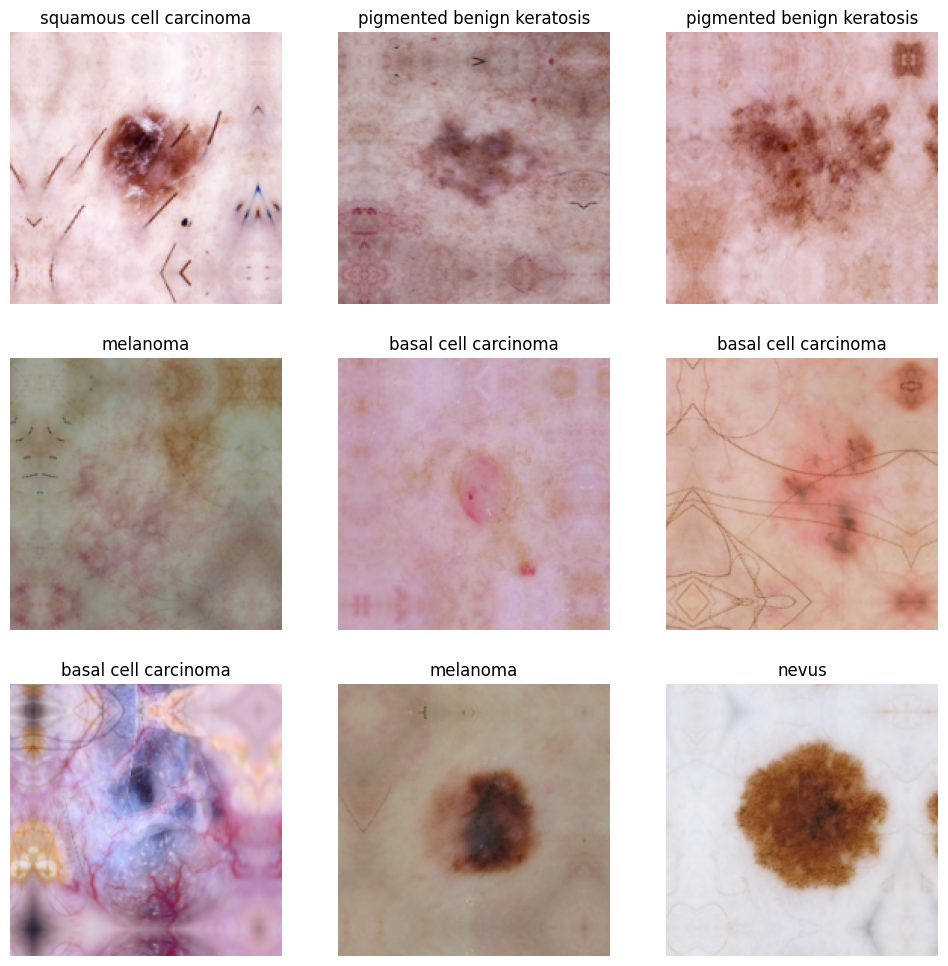

In [ ]:
# visualizing how augmentation strategy is working
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
# Adding slightly higher dropout with smaller architecture

model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))

])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 32)      2432      
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 64)        51264     
                                                      

Epoch 1/20
56/56 - 10s - loss: 2.0690 - accuracy: 0.2109 - val_loss: 1.9829 - val_accuracy: 0.2416 - 10s/epoch - 185ms/step
Epoch 2/20
56/56 - 6s - loss: 1.8671 - accuracy: 0.3125 - val_loss: 1.6601 - val_accuracy: 0.4161 - 6s/epoch - 103ms/step
Epoch 3/20
56/56 - 6s - loss: 1.6498 - accuracy: 0.4079 - val_loss: 1.6022 - val_accuracy: 0.4251 - 6s/epoch - 103ms/step
Epoch 4/20
56/56 - 6s - loss: 1.6110 - accuracy: 0.4336 - val_loss: 1.5563 - val_accuracy: 0.4407 - 6s/epoch - 103ms/step
Epoch 5/20
56/56 - 6s - loss: 1.5063 - accuracy: 0.4794 - val_loss: 1.5042 - val_accuracy: 0.4541 - 6s/epoch - 102ms/step
Epoch 6/20
56/56 - 6s - loss: 1.5445 - accuracy: 0.4397 - val_loss: 1.5108 - val_accuracy: 0.4832 - 6s/epoch - 102ms/step
Epoch 7/20
56/56 - 6s - loss: 1.4841 - accuracy: 0.4715 - val_loss: 1.5016 - val_accuracy: 0.4989 - 6s/epoch - 101ms/step
Epoch 8/20
56/56 - 6s - loss: 1.4887 - accuracy: 0.4693 - val_loss: 1.5352 - val_accuracy: 0.4631 - 6s/epoch - 102ms/step
Epoch 9/20
56/56 - 6s 

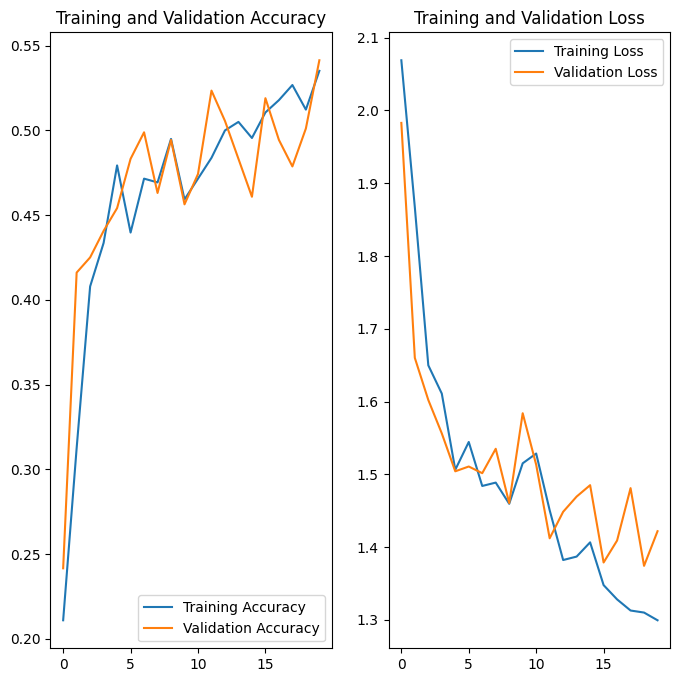

In [ ]:
# Model Training

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose =  2
)

## plotting training history
plot_training_history(history)

### Basic Data Augmentaions Model - Initial Observations on Overfitting or Underfitting.
- Significant Drop In training accuracy while validation accuracy remains consistent.
- Siginificantly less variance in training and validation data , augumentation and dropout has helped reduce overfitting.
- Accuracy has room for improvement.

### Analyse Data Set Class Distrubution for imbalance check.

,Class,Size,Proportion
1,pigmented benign keratosis,462,51
8,melanoma,438,48
3,basal cell carcinoma,376,41
6,nevus,357,39
5,squamous cell carcinoma,181,20
0,vascular lesion,139,15
4,actinic keratosis,114,12
2,dermatofibroma,95,10
7,seborrheic keratosis,77,8


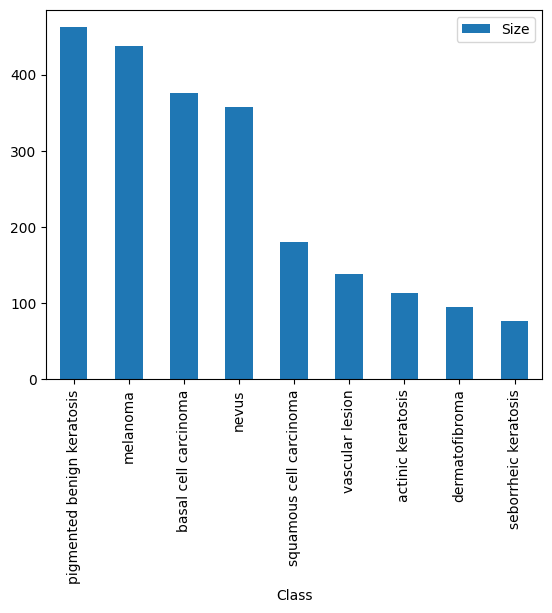

<Figure size 1000x1000 with 0 Axes>

In [ ]:
from pathlib import Path

# Create a dictionary to store the class distribution
class_distribution = {}

# Iterate over the subdirectories in the Train directory
for subdir in data_dir_train.iterdir():
    # Get the name of the subdirectory
    subdir_name = subdir.name

    # Check if the subdirectory is a directory
    if subdir.is_dir():
        # Get the number of images in the subdirectory
        num_images = len(list(subdir.iterdir()))

        # Add the number of images to the class distribution dictionary
        class_distribution[subdir_name] = num_images

original_class_distrubution = pd.DataFrame.from_dict(class_distribution,orient='index',columns=['Size'])
original_class_distrubution.index.name = 'Class'
original_class_distrubution = original_class_distrubution.reset_index().sort_values(by='Size',ascending=False)
original_class_distrubution['Proportion'] = original_class_distrubution['Size'] // original_class_distrubution.shape[0]
display(original_class_distrubution)
# create a bar plot
original_class_distrubution.plot(kind='bar', x='Class', y='Size')
plt.figure(figsize=(10,10))
plt.show()

- Q. Which class has the least number of samples?
    - seborrheic keratosis has least samples. (77)
- Q. Which classes dominate the data in terms proportionate number of samples?
    - pigmented benign keratosis , melanoma dominate. Closely followed by  basal cell carcinoma and nevus.

### Using Augmented to create images to fix class imbalance issues

In [ ]:
#generating images
path_to_training_dataset = "./Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class

Initialised with 114 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E42EC61BFD0>: 100%|██████████| 500/500 [00:14<00:00, 35.41 Samples/s]


Initialised with 376 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E42EC6774F0>: 100%|██████████| 500/500 [00:14<00:00, 35.35 Samples/s]


Initialised with 95 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E42EC814100>: 100%|██████████| 500/500 [00:14<00:00, 33.76 Samples/s]


Initialised with 438 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7E42ECC4D9C0>: 100%|██████████| 500/500 [01:17<00:00,  6.46 Samples/s]


Initialised with 357 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1011x713 at 0x7E42ECD0C550>: 100%|██████████| 500/500 [01:20<00:00,  6.18 Samples/s]


Initialised with 462 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E436F61BE20>: 100%|██████████| 500/500 [00:14<00:00, 34.16 Samples/s]


Initialised with 77 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E42ECDAFD90>: 100%|██████████| 500/500 [00:35<00:00, 13.97 Samples/s]


Initialised with 181 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E435F72F850>: 100%|██████████| 500/500 [00:14<00:00, 35.65 Samples/s]


Initialised with 139 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E43722F7610>: 100%|██████████| 500/500 [00:14<00:00, 34.18 Samples/s]


In [ ]:
# total count of augmented images
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train) # 500 * 9

4500


### Checking Class Distrubution After Augmentations

In [ ]:
# Creating a Path and Label Mapping for Augmented Images

path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
display(random.sample(path_list_new,9))

lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
random.sample(lesion_list_new,9)

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025285.jpg_b2c2ec3e-2ad1-4f15-a477-1d31bf6811fe.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027210.jpg_db6395ef-343d-4454-9751-9992193e8820.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030986.jpg_fc3d1782-d939-404b-a6f8-8d728e8a523e.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030408.jpg_a1b37d55-b695-48ee-948d-bce826673477.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026626.jpg_cf47710a-1296-491c-8af3-b378ef908f55.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermat

['vascular lesion',
 'dermatofibroma',
 'actinic keratosis',
 'nevus',
 'melanoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'vascular lesion',
 'pigmented benign keratosis']

In [ ]:
# Creating a Mapping Dataframe
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
all_image_with_labels = original_df.append(df2)
print(all_image_with_labels.shape) # (9*500) + 2239

(6739, 2)


<ipython-input-24-be4772ab78c3>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_image_with_labels = original_df.append(df2)


**all_image_with_labels** contains all training images including those generated by Augemtor. Total Images are **6739**.

In [ ]:
# Checking Class Distrubution
print(all_image_with_labels['Label'].value_counts(ascending=False))

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64


### Training a Final Model by using Augementor generated images

In [ ]:
# Creating Datasets

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Using a deeper architecture as Data is Balanced with more samples

model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(256,kernel_size=(11,11),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(9,activation='softmax'))

#choose an appropirate optimiser and loss function - Adam optimiser
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=2,factor=0.2, min_lr=1e-5)
#opt=tf.keras.optimizers.Adam()
model.compile(optimizer="Adam",loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["accuracy"])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 41, 41, 128)      

Epoch 1/30
169/169 - 39s - loss: 2.1318 - accuracy: 0.1680 - val_loss: 1.9752 - val_accuracy: 0.1990 - lr: 0.0010 - 39s/epoch - 231ms/step
Epoch 2/30
169/169 - 10s - loss: 2.0818 - accuracy: 0.2001 - val_loss: 1.9415 - val_accuracy: 0.2123 - lr: 0.0010 - 10s/epoch - 57ms/step
Epoch 3/30
169/169 - 10s - loss: 1.9118 - accuracy: 0.2409 - val_loss: 1.8009 - val_accuracy: 0.2613 - lr: 0.0010 - 10s/epoch - 58ms/step
Epoch 4/30
169/169 - 10s - loss: 1.8602 - accuracy: 0.2639 - val_loss: 1.9594 - val_accuracy: 0.2390 - lr: 0.0010 - 10s/epoch - 58ms/step
Epoch 5/30
169/169 - 10s - loss: 1.7706 - accuracy: 0.3088 - val_loss: 1.7901 - val_accuracy: 0.3170 - lr: 0.0010 - 10s/epoch - 57ms/step
Epoch 6/30
169/169 - 10s - loss: 1.7248 - accuracy: 0.3233 - val_loss: 1.5819 - val_accuracy: 0.3808 - lr: 0.0010 - 10s/epoch - 57ms/step
Epoch 7/30
169/169 - 10s - loss: 1.6396 - accuracy: 0.3648 - val_loss: 1.4970 - val_accuracy: 0.4120 - lr: 0.0010 - 10s/epoch - 57ms/step
Epoch 8/30
169/169 - 10s - loss: 

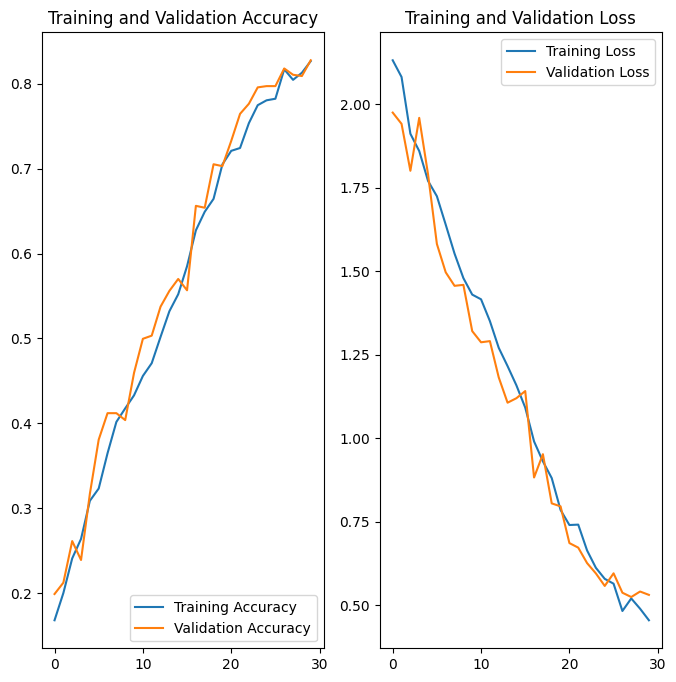

In [ ]:
# Model Training
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[learn_control],
  verbose =  2
)

# plotting training history
plot_training_history(history,epochs)

### Verifiying Model performance on Unseen Test data

1/1 [==============================] - 0s 21ms/step
Actual Class is nevus,Predicted Class nevus


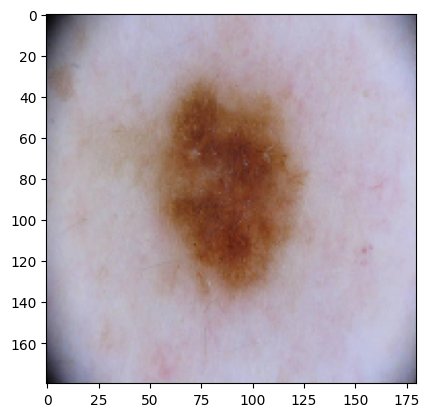

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Test_image_path = os.path.join(data_dir_test, skin_cancer_class_names[1], '*')
# Test_image = glob(Test_image_path)
Test_image = load_img("./Skin cancer ISIC The International Skin Imaging Collaboration/Test/nevus/ISIC_0000015.jpg",target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred_label = np.argmax(pred)
print(f"Actual Class is nevus,Predicted Class {class_names[pred_label]}")

### Analysing Results
- Final Augmented model perfroms really well on the validation dataset , compared to previous 2 models.
- Dropouts and Class balancing have greately improved model genralization power.
- We Managed to Sucessfully tackle the issue of overfitting  , as train and validation have greatly improved and we see much lesser spikes during training.
- We have boosted models genraliation ability and have achieved a good accuracy of 80% compared to 50% in the earlier approaches.